In [ ]:
%pip install mne 
%pip install eeglab
%pip install matlab.engine


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import mne  # If using MNE to handle MFF files
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import glob
plt.ion()  # Enable interactive mode

In [4]:
root_dir = "C:/Users/emros/OneDrive/Desktop/Eyes/Eyes Closed"
file_paths = glob.glob(os.path.join(root_dir, "**", "*.mff"), recursive=True)

In [5]:
all_epochs = []  # List to store epochs for all participants

In [ ]:

for file in file_paths:
    #print(f"Processing: {file}")
    try:
        # Load the file
        raw = mne.io.read_raw_egi(file, preload=True)

        # Apply the notch filter (e.g., 50 Hz or 60 Hz, depending on your region)
        raw.notch_filter(freqs=60.0)  # Example for 50 Hz with a notch width of 2 Hz

        # Apply filtering
        raw.filter(l_freq=0.1, h_freq=30.0)

        # Bad channel detection
        std_per_channel = np.std(raw.get_data(), axis=1)
        threshold = np.mean(std_per_channel) + 3 * np.std(std_per_channel)
        bad_channels = [raw.ch_names[i] for i in range(len(std_per_channel)) if std_per_channel[i] > threshold]
        raw.info['bads'] = bad_channels
        #print("  Detected bad channels:", bad_channels)

        # Re-reference
        raw.set_eeg_reference('average')

        # ICA for artifact removal
        ica = mne.preprocessing.ICA(n_components=65, random_state=42)
        ica.fit(raw)
        ica.exclude = [0, 1]  # Adjust based on inspection
        raw = ica.apply(raw)

        # Epoching
        epochs = mne.make_fixed_length_epochs(raw, duration=2.0, overlap=0.5)

        # Append the epochs to the list for averaging later
        all_epochs.append(epochs.get_data())

        # Save processed data
        save_path = file.replace(".mff", "-processed.fif")
        raw.save(save_path, overwrite=True)
        #print(f"  Saved: {save_path}")

    except Exception as e:
        print(f"  Error processing {file}: {e}")


In [ ]:
#for file in file_paths: 
    # print(f"Processing: {file}")
 #   try:
        # Load the file
 #       raw = mne.io.read_raw_egi(file, preload=True)

        # Get total duration in seconds
 #       total_duration = raw.times[-1]  # Last time point in seconds
        # print(f"Total recording duration: {total_duration:.2f} seconds")

        # Ensure we have at least 5 minutes (300 seconds)
 #       if total_duration < 300:
  #          raise ValueError(f"Recording is too short! Only {total_duration:.2f} seconds available.")

        # Extract full 5-minute segment (assuming no epoching yet)
   #     raw_5min = raw.copy().crop(tmin=0, tmax=300)

        # If already epoching, make sure all epochs together cover 5 min
 #       epoch_duration = 2.0  # Example: 2-second epochs
  #      num_epochs_needed = int(300 / epoch_duration)

  #      if len(epochs) < num_epochs_needed:
  #          raise ValueError(f"Not enough epochs! Only {len(epochs)} epochs available.")

        # If using epochs, concatenate them
   #     full_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_samples)

   #     print(f"Full data shape: {full_data.shape}")

  #  except Exception as e:
  #      print(f"Error processing {file}: {e}")


In [7]:
# Specify the expected number of channels (e.g., 65 channels)
expected_n_channels = 65

# Filter out epochs that don't match the expected shape
filtered_epochs = [epochs for epochs in all_epochs if epochs.shape[1] == expected_n_channels]

# Now concatenate the remaining epochs
all_epochs_data = np.concatenate(filtered_epochs, axis=0)

# Check the shape to ensure it's correct
print(f"Shape of filtered epochs data: {all_epochs_data.shape}")


Shape of filtered epochs data: (3419, 65, 2000)


In [ ]:
# Ensure the info structure is available
info = raw.info  # Assuming 'raw' is the last processed raw object, or generate info from your setup

# Create an EpochsArray object with the filtered epochs data
epochs_data = mne.EpochsArray(all_epochs_data, info)

# Check the shape of the created Epochs object
print(f"EpochsArray shape: {epochs_data.get_data().shape}")

# Plot the epochs (this shows a summary of the data)
epochs_data.plot(title='Filtered Epochs')



Not setting metadata
3419 matching events found
No baseline correction applied
0 projection items activated
EpochsArray shape: (3419, 65, 2000)
Using matplotlib as 2D backend.


In [ ]:
# Visualize only the first 5 epochs (or any specific epochs)
epochs_data.plot(picks=range(65), n_epochs=5, title="Selected Epochs")

# Or visualize only specific channels (e.g., first 10 channels)
epochs_data.plot(picks=range(10), n_epochs=5, title="Selected Channels")


KeyboardInterrupt: 

Not setting metadata
4229 matching events found
No baseline correction applied
0 projection items activated


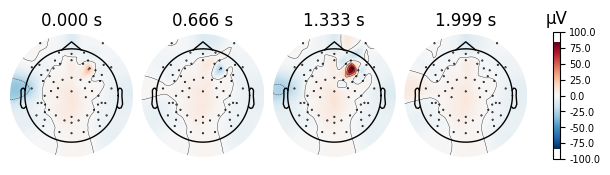

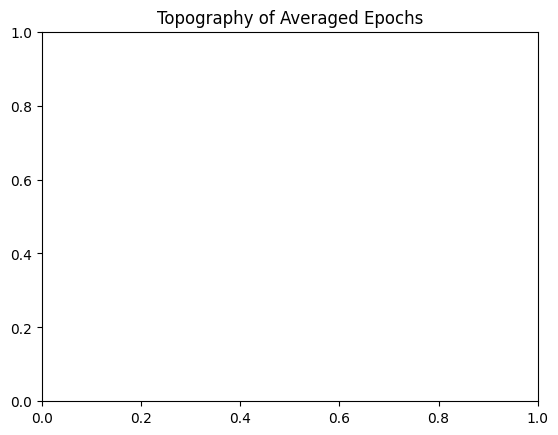

In [ ]:
# Plot the topography of the first epoch (i.e., spatial distribution of activity)
epochs_data.get_data()[0, :, :]  # Get the first epoch's data (channels x samples)
epochs_data1 = mne.EpochsArray(all_epochs_data, info)
average_data = epochs_data1.average()
average_data.plot_topomap(times='auto')
# Alternatively, to set a custom title, you can use the `matplotlib` API:
import matplotlib.pyplot as plt

# After plotting, you can set the title with matplotlib
plt.title("Topography of Averaged Epochs")
plt.show()

In [35]:
# Now compute the average epoch across all participants (axis 0 averages across participants)
average_epochs = np.mean(all_epochs_data, axis=0)  # Averages across participants (axis 0)

# Check the shape of the average epochs to ensure it's correct
print(f"Shape of averaged epochs: {average_epochs.shape}")


Shape of averaged epochs: (65, 2000)


In [36]:
print(f"Shape of all epochs data: {all_epochs_data.shape}")
average_epochs = np.mean(all_epochs_data, axis=0)
print(f"Shape of averaged epochs: {average_epochs.shape}")


Shape of all epochs data: (4229, 65, 2000)
Shape of averaged epochs: (65, 2000)


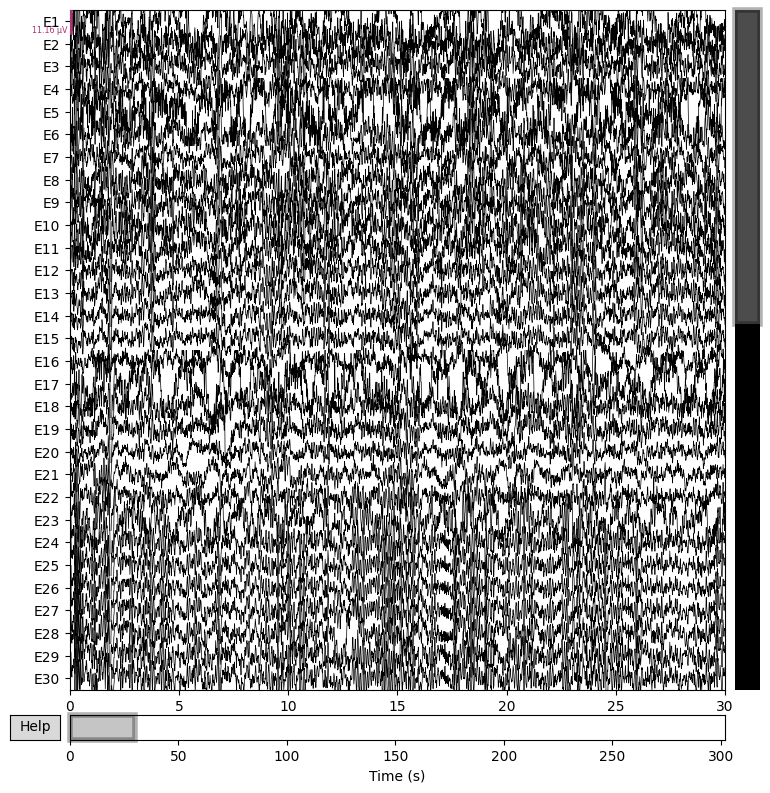

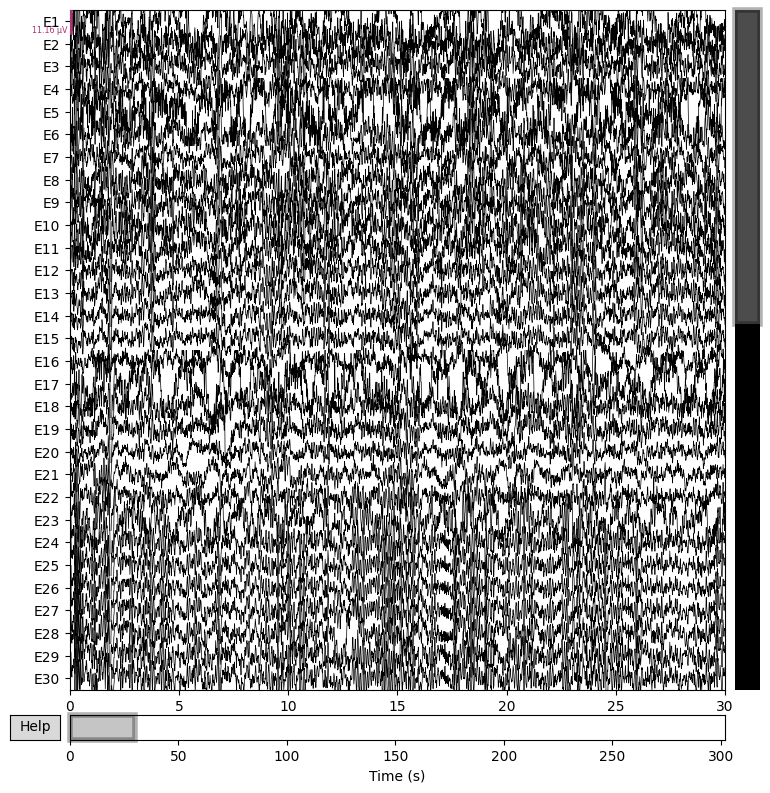

In [38]:
raw.plot(duration=30, n_channels=30, scalings='auto', title='Raw EEG Data')


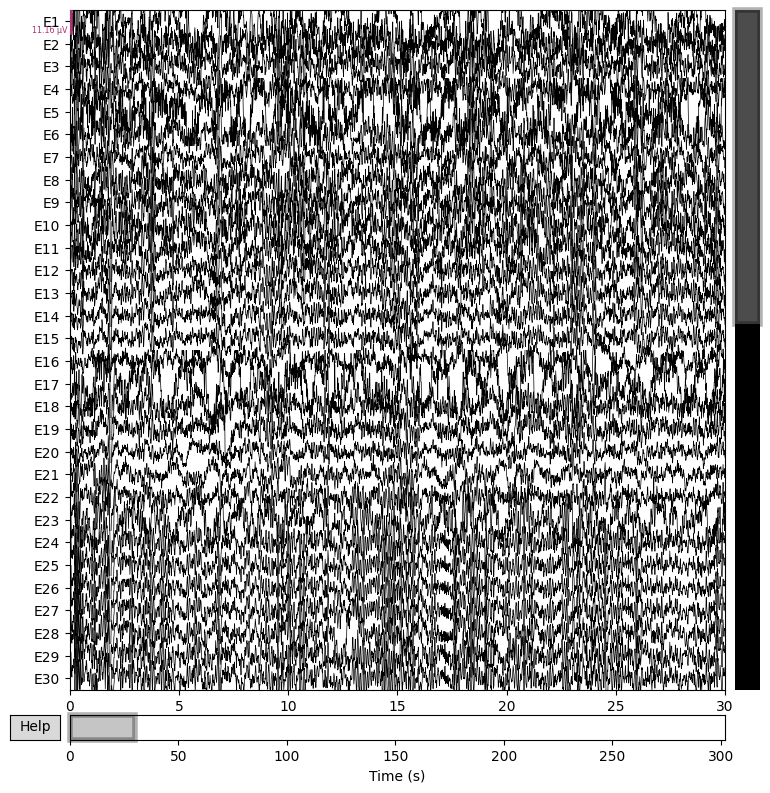

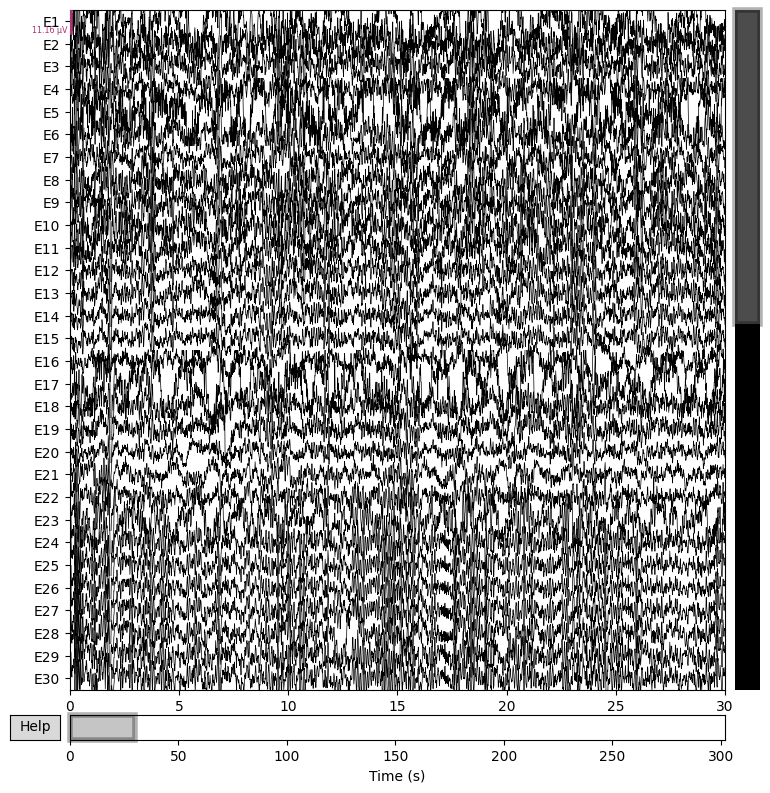

In [39]:
raw.plot(duration=30, n_channels=30, scalings='auto', title='Filtered EEG Data')


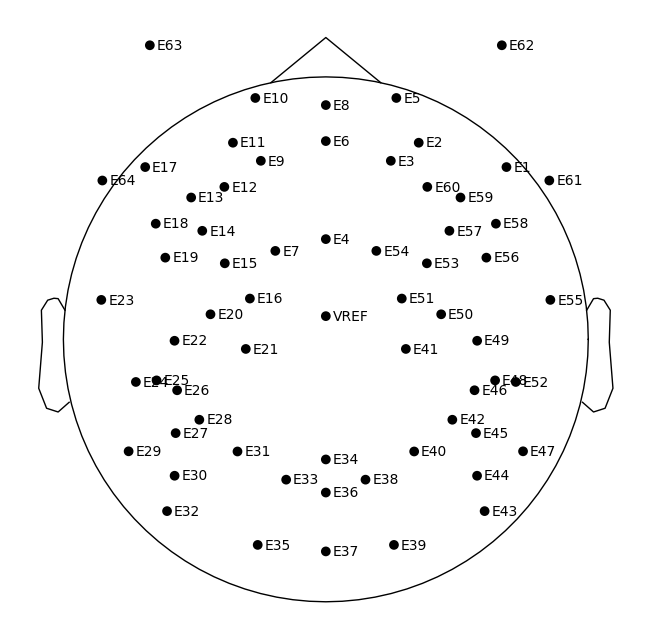

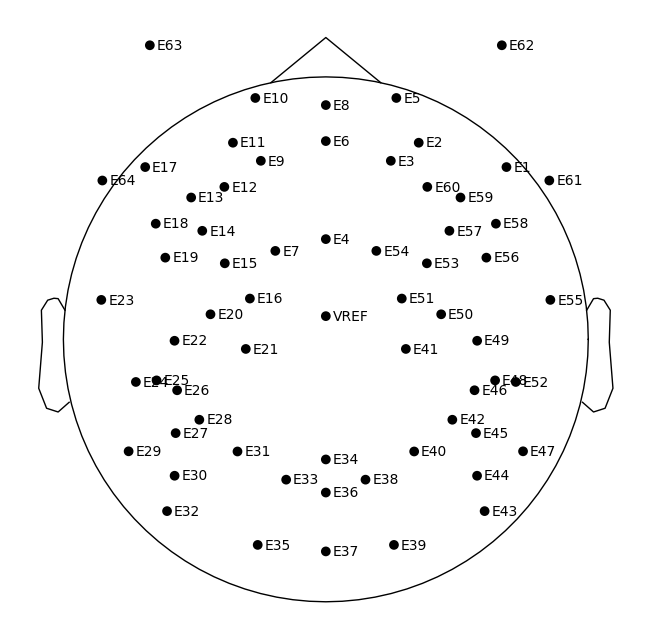

In [40]:
raw.plot_sensors(show_names=True, title='Sensor Map with Bad Channels')


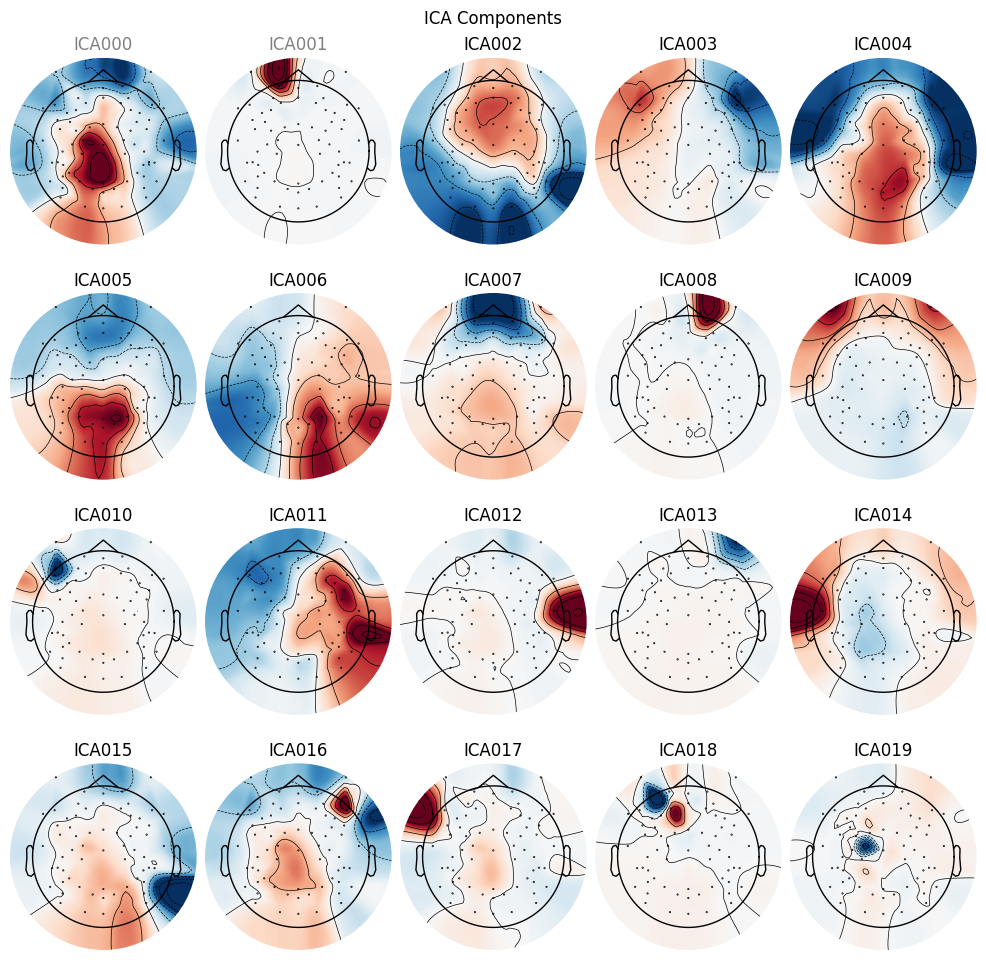

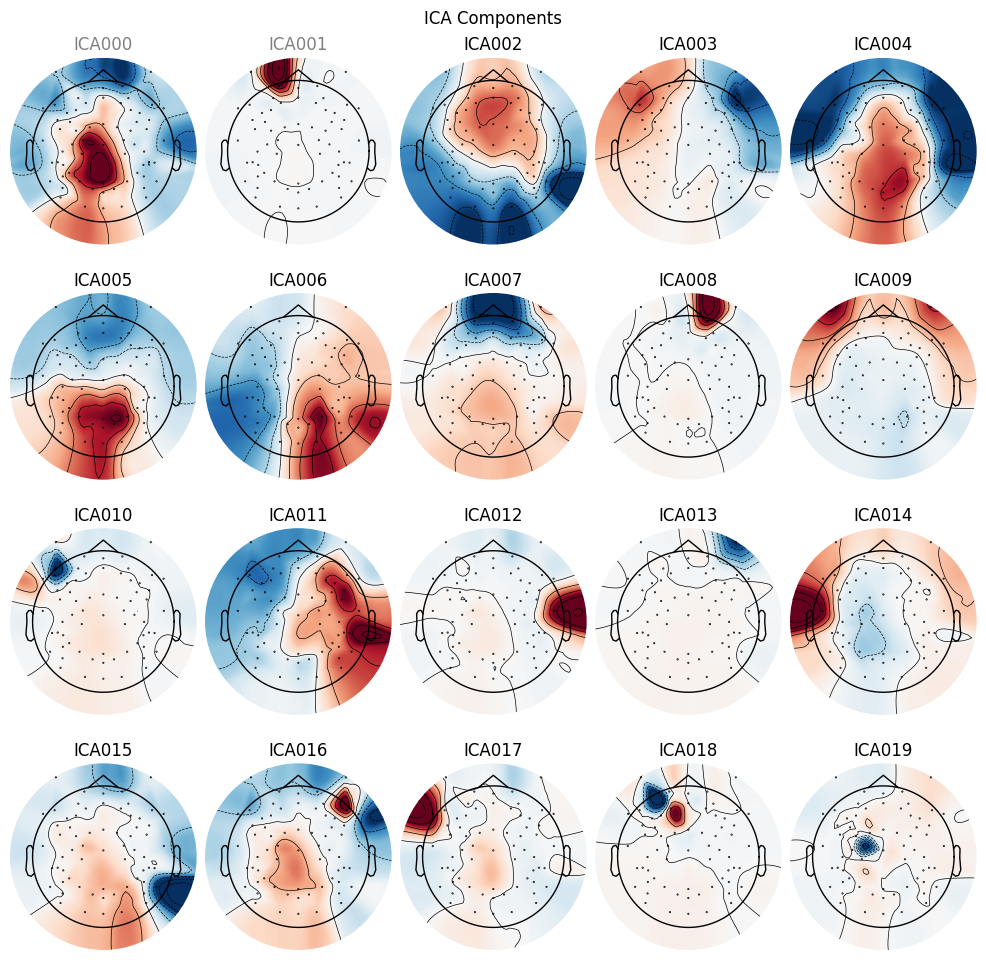

In [41]:
ica.plot_components(title='ICA Components')


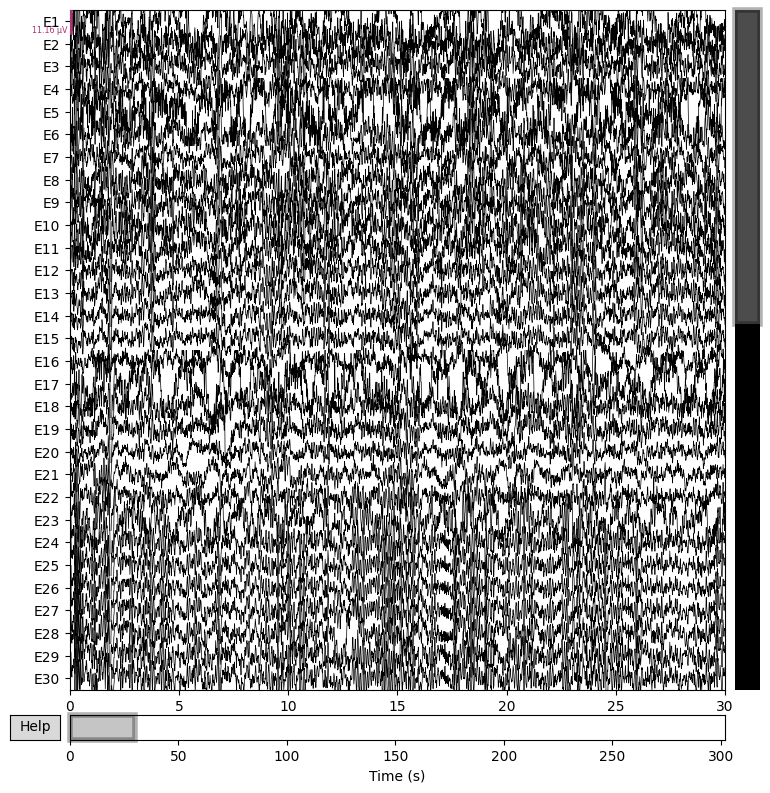

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 65 PCA components


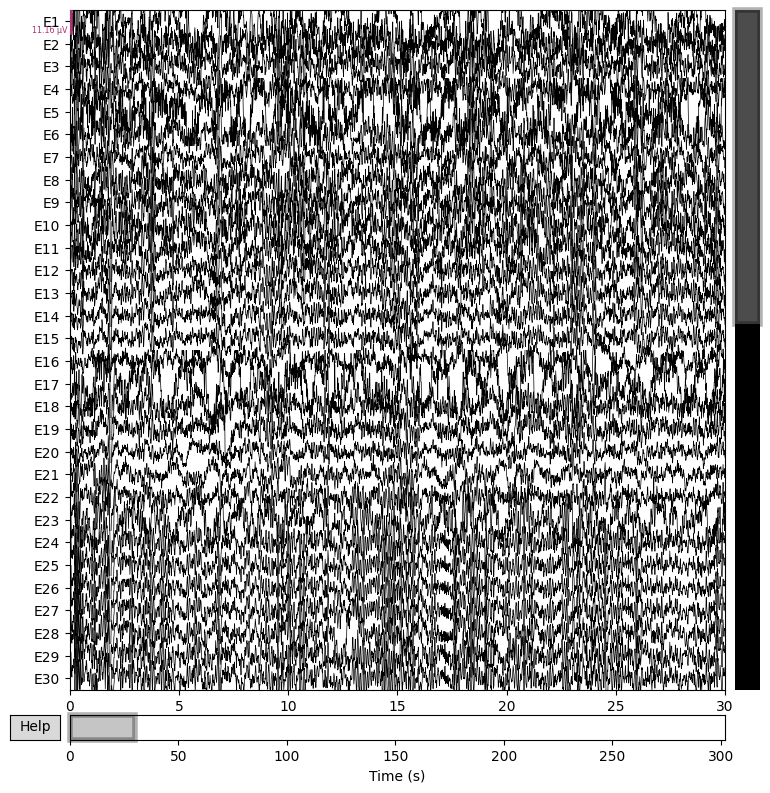

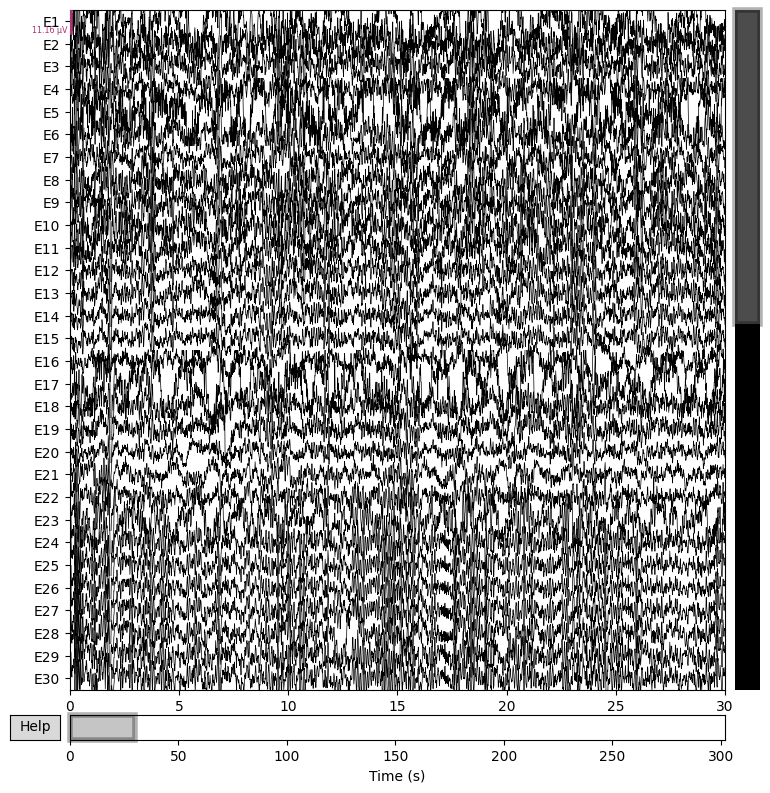

In [43]:
# Compare original vs processed data
raw.plot(duration=30, n_channels=30, scalings='auto', title='Original Raw Data')
raw_after_ica = ica.apply(raw)
raw_after_ica.plot(duration=30, n_channels=30, scalings='auto', title='After ICA Artifact Removal')


Opening raw data file C:\Users\emros\OneDrive\Desktop\EYesss\Closed\EC_9895_Closed_20240627_010115-processed.fif...
    Range : 0 ... 301997 =      0.000 ...   301.997 secs
Ready.
Reading 0 ... 301997  =      0.000 ...   301.997 secs...


C:\Users\emros\AppData\Local\Temp\ipykernel_15756\1652004015.py:1: RuntimeWarning: This filename (C:\Users\emros\OneDrive\Desktop\EYesss\Closed\EC_9895_Closed_20240627_010115-processed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  processed_raw = mne.io.read_raw_fif(save_path, preload=True)


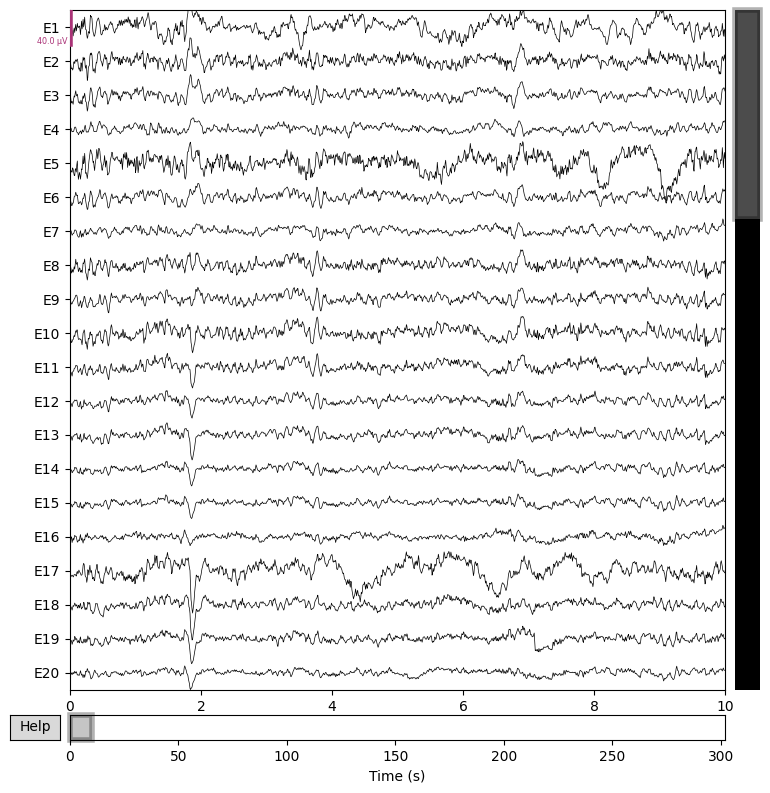

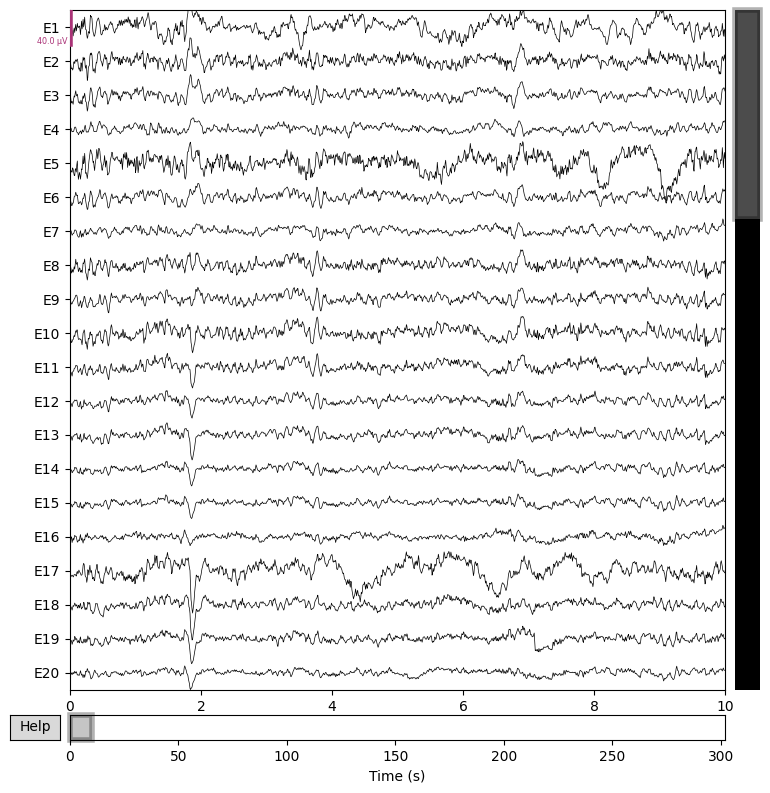

In [44]:
processed_raw = mne.io.read_raw_fif(save_path, preload=True)
processed_raw.plot(title='Processed EEG Data')


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


c:\Users\emros\anaconda33\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


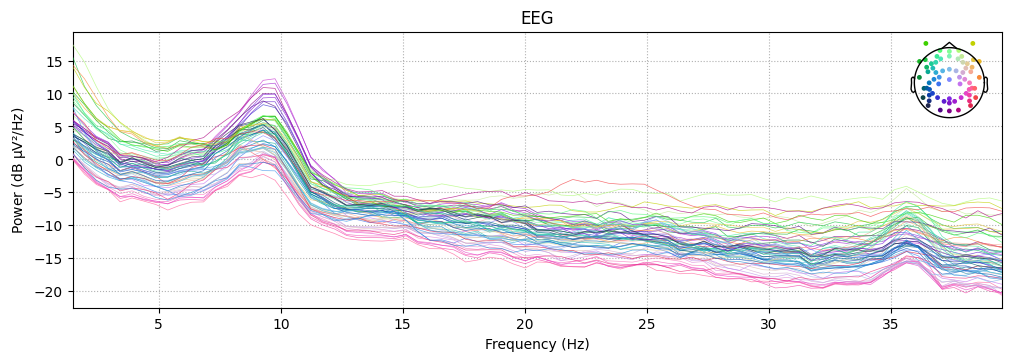

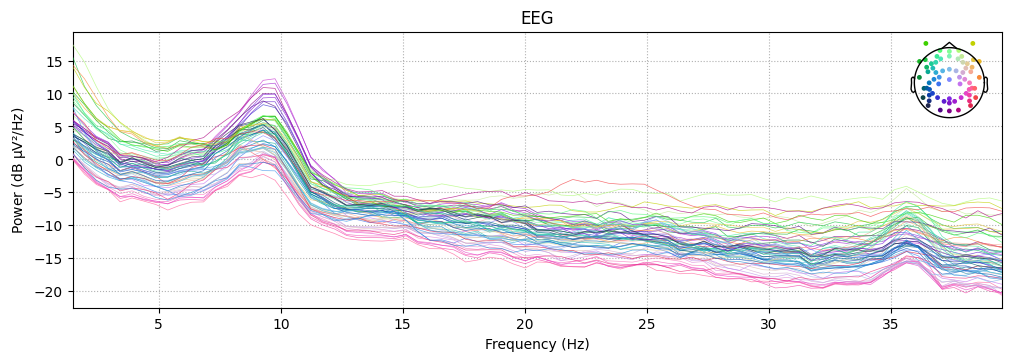

In [45]:
raw.plot_psd(fmin=1, fmax=40)

Not setting metadata
4229 matching events found
No baseline correction applied
0 projection items activated


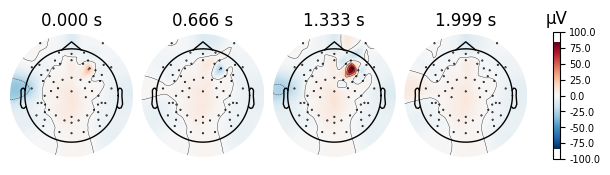

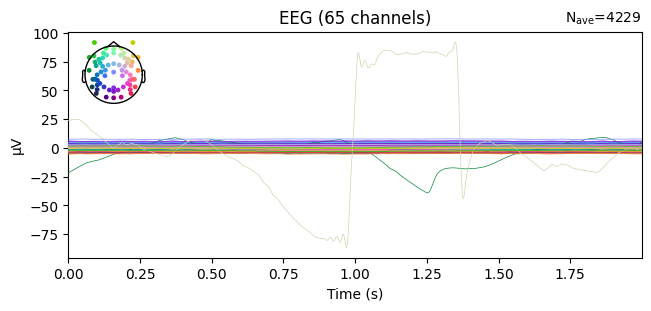

ValueError: 'Cz' is not in list

In [ ]:

import mne
import matplotlib.pyplot as plt

# Assuming all_epochs_data is already concatenated and contains the data from all participants
# You might have done something like:
all_epochs_data = np.concatenate(filtered_epochs, axis=0)

# Create an Epochs object from the concatenated epochs (assuming 'info' from raw data)
epochs_data = mne.EpochsArray(all_epochs_data, info)

# Average the data across all epochs
average_data = epochs_data.average()

# Plot the topography of the averaged data (spatial distribution of activity)
average_data.plot_topomap(times='auto')

# To visualize the time series of the averaged data across all channels:
average_data.plot()

# Alternatively, if you're interested in a specific channel (e.g., 'Cz'), plot the time series for that channel:
average_data.plot([raw.info['ch_names'].index('E3','E6','E8','E9')])  # Adjust channel name as needed

# Show the plot
plt.show()

